In [1]:
! pip install Pillow

In [2]:
from PIL.Image import fromarray as toimage

from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.datasets import cifar10
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.layers import Input, Activation, merge, Dense, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.utils import plot_model

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [0]:
# CIFAR-10 の画像をロードする
# 普通はネットからダウンロードしてきてそれを読み込むのだが、
# KerasではCIFAR10をダウンロードしてきて読み込むところまでを
# やってくれる機能があるのでそれを使っている
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

#Cifer10のデータ形式http://aidiary.hatenablog.com/entry/20151014/1444827123
#50000枚（各クラス5000枚）の訓練画像と10000枚（各クラス1000枚）のテスト画像に分割されている
#PythonのcPickle形式で提供されている(画像ファイルが60000枚提供されているわけではなく、ピクセルデータ配列としてPythonから簡単に読み込める形式で提供されている)


# CIFAR-10の教師データは 0 〜 9 までの数字になっているが、これだと人はわかりにくいので
# 0 → airplane, 1 → automobile…のような対応関係を配列で持っておく
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

In [4]:
# 画像が50000枚、行数が32、列数が32、チャンネルが3（RGB）であることを意味する。配列には0-255の画素値が入っている
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


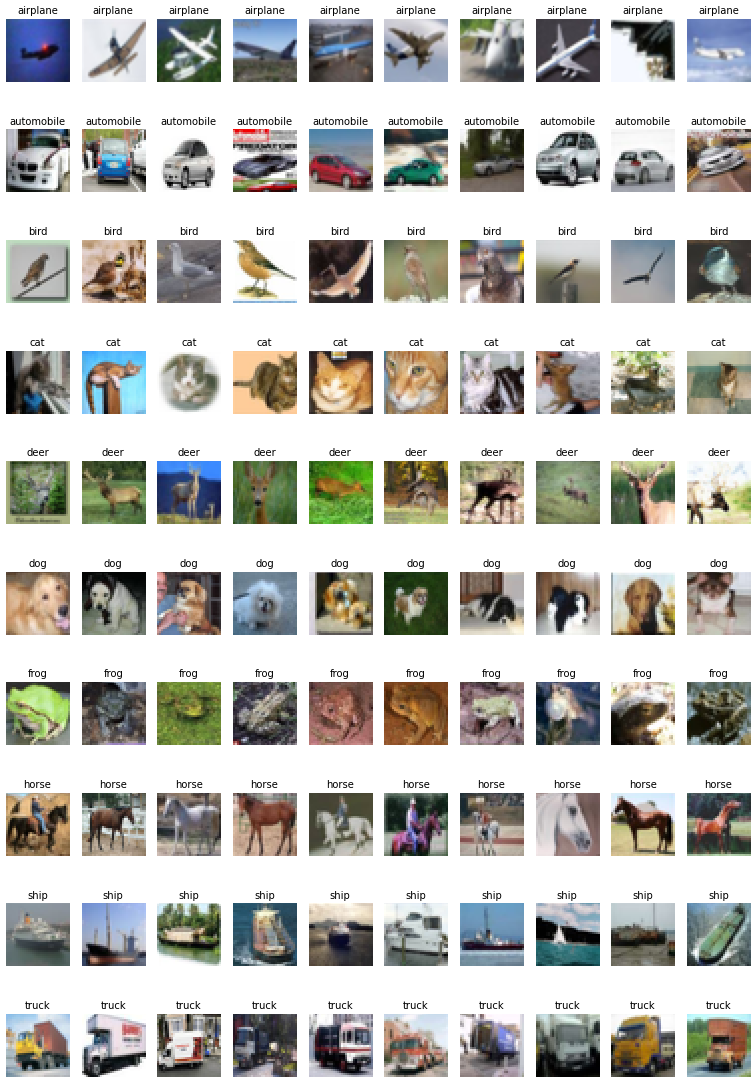

In [5]:
import numpy as np
import matplotlib.pyplot as plt

nclasses = 10
pos = 1
plt.figure(figsize=(16,24), dpi=60)

# matplotlib で学習用画像を10個ずつ表示する
for targetClass in range(nclasses):
    targetIdx = []
    # クラスclassIDの画像のインデックスリストを取得
    for i in range(len(y_train)):
        if y_train[i][0] == targetClass:
            targetIdx.append(i)

    # 各クラスからランダムに選んだ最初の10個の画像を描画
    np.random.shuffle(targetIdx)
    for idx in targetIdx[:10]:
        # X_train[idx] は3次元の行列になっており、そのままだと数字の羅列が表示されるだけなので
        # toimage を使って画像に変換してから表示する
        img = toimage(X_train[idx])
        plt.subplot(10, 10, pos)
        plt.imshow(img)
        plt.axis('off')
        plt.title(cifar10_labels[y_train[idx][0]])
        pos += 1

plt.show()

In [0]:
# 正規化するためにfloatに変換しておく
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255.0
X_test /= 255.0

# one-hot vector に変換する
# たとえば 4 ではなくて [0, 0, 0, 0, 1, 0, 0, 0, 0, 0] のようなデータにする
# クラスは0〜9で表現されるがこれは本来名義尺度なので、
# このようなデータは one-hot に変換したほうがよい
# 順序尺度、間隔尺度、比例尺度の場合はone-hotにはしなくてよいが、
# その場合はそもそも回帰の問題として解くべき
n_classes = 10
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

In [0]:
import keras
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.loss = []
        self.val_loss = []
        self.acc = []
        self.val_acc = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        from IPython.display import clear_output

        self.logs.append(logs)
        self.x.append(self.i)
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        
        clear_output(wait=True)
        plt.subplot(1, 2, 1)
        plt.plot(self.x, self.loss, label="loss")
        plt.plot(self.x, self.val_loss, label="val_loss")
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(self.x, self.acc, label="acc")
        plt.plot(self.x, self.val_acc, label="val_acc")
        plt.legend()
                
        plt.show()

In [8]:
#
# ResNet のモデルを定義するセル
#

def _shortcut(inputs, residual):
  
    res_channel = n_filters = residual._keras_shape[3]
    in_channel = inputs._keras_shape[3]

    if res_channel == in_channel:
        shortcut = inputs
    else:
        shortcut = Convolution2D(n_filters, (1,1), strides=(1,1))(inputs)

    # 2つを足す
    return add([shortcut, residual])


# ResBlock を定義
def _resblock(n_filters, strides=(1,1), shortcut=True):
    def f(inputs):
        x = inputs

        x = Convolution2D(n_filters, (3,3), strides=strides, kernel_initializer='he_normal', padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Activation('relu')(x)
        x = BatchNormalization()(x)
        
        x = Convolution2D(n_filters, (3,3), strides=(1,1), kernel_initializer='he_normal', padding='same')(x)
        x = BatchNormalization()(x)

        if shortcut:
            return _shortcut(inputs, x)
        else:
            return x

    return f

def _append_resblocks(n_filters, depth=1):

    def f(inputs):
        x = inputs
        for i in range(depth):
           
            if i == 0:
                x = _resblock(n_filters=n_filters, strides=(2,2), shortcut=False)(x)  
            else:
                x = _resblock(n_filters=n_filters, strides=(1,1), shortcut=True)(x)  
            
        return x
    
    return f
  
def resnet():
    k = 3
    N = 4
    init_filters = 16

    inputs = Input(shape=(32, 32, 3))
    x = inputs
    #x = Convolution2D(init_filters, (7,7), strides=(2,2), kernel_initializer='he_normal', padding='same')(x)
    x = _append_resblocks(init_filters * 1 * k, N)(x)
    x = _append_resblocks(init_filters * 2 * k, N)(x)
    x = _append_resblocks(init_filters * 4 * k, N)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

model = resnet()

batch_size = 256
epochs = 300
learning_rate = 0.05

sgd = SGD(lr=learning_rate, momentum=0.9, decay=0.0001, nesterov=True)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
print('params: ', '{:,}'.format(model.count_params()))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 48)   1344        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 48)   192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 16, 16, 48)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2)

datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=[0.9, 1.2],
    horizontal_flip=True)
datagen.fit(x_train)

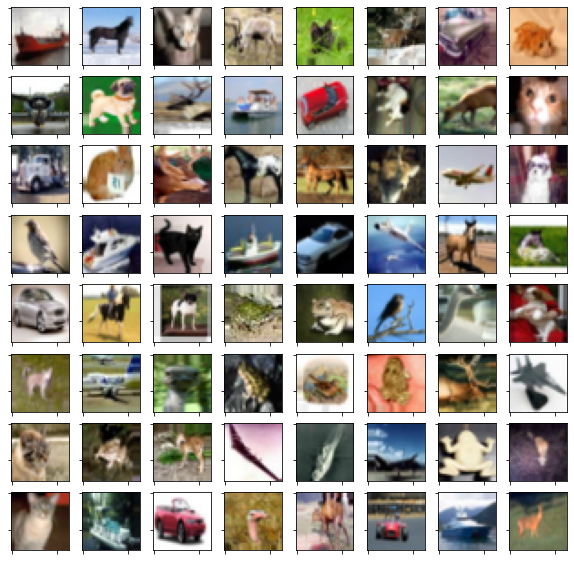

In [10]:
from keras.preprocessing import image
def show_imgs(imgs, row, col):
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(imgs):
        plt.subplot(row, col, i+1)
        plt.tick_params(labelbottom=False)
        plt.tick_params(labelleft=False)
        plt.imshow(img)
    plt.show()

n_max_img = 64
imgs = []
gen_imgs = datagen.flow(X_train, batch_size=n_max_img).next()
for img in gen_imgs:
    imgs.append(image.array_to_img(img, scale=True))
show_imgs(imgs, row=8, col=8)

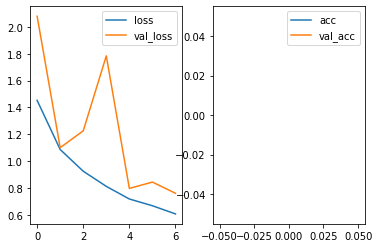

Epoch 8/300
130/156 [========================>.....] - ETA: 3s - loss: 0.5558 - accuracy: 0.8055

In [0]:
# 1 epoch ごとに　weights.01.hdf5, weights.02.hdf5 … のようにモデルを保存してくれる
callback_cp = ModelCheckpoint(filepath='weights.{epoch:02d}.hdf5')

# 1 epoch ごとに val_acc　に変化があるか調べて、殆ど変わってなかったら学習を打ち切る
callback_es = EarlyStopping(monitor='loss', patience=50, mode='auto', verbose=1)

# callback_ls = LearningRateScheduler(lambda ep: float(learning_rate *  0.2 ** (ep * 4 // epochs)), verbose=0)

callback_plot = PlotLosses()

steps_per_epoch = x_train.shape[0] // batch_size

# 学習する
h = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_val, y_val),
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs,
                        callbacks=[callback_cp, callback_es, callback_plot],
                        verbose=1)

# 学習が終わった最終状態を保存する
model.save('model.hdf5')

In [0]:
import numpy as np
import matplotlib.pyplot as plt

epoch = np.arange(len(h.history['acc']))

# accuracy と validation accuracy の推移をプロットする
plt.title('Accuracy')
plt.ylim(0.0, 1.0)
plt.plot(epoch, h.history['acc'], label='train')
plt.plot(epoch, h.history['val_acc'], label='validation')
plt.legend()
plt.show()

In [0]:
results = model.predict(X_test)

pos = 1
plt.figure(figsize=(16,24), dpi=60)

for i in range(100):
  img = toimage(X_test[i])
  label = results[i].argmax()
  plt.subplot(10, 10, pos)
  plt.imshow(img)
  plt.axis('off')
  plt.title(cifar10_labels[label])
  pos += 1        

plt.show()